Importing Libraries

In [35]:
import numpy as np 
import pandas as pd 
import seaborn; seaborn.set()
from sklearn.metrics import mean_squared_error

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Data

In [36]:
df = pd.read_csv('btc_4h.csv', parse_dates=["datetime"])

In [37]:
from datetime import datetime

In [38]:
def test_for_stationary(ts):
    result = adfuller(ts, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')

In [39]:
df

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13155.38,13410.03,1676.204807
1,2018-01-01 09:30:00,13434.98,13818.55,13322.15,13570.35,1302.214836
2,2018-01-01 13:30:00,13569.98,13735.24,13001.13,13220.56,1319.755931
3,2018-01-01 17:30:00,13220.56,13330.00,12750.00,13247.00,1831.933153
4,2018-01-01 21:30:00,13247.00,13290.65,12940.00,13240.37,1092.337234
...,...,...,...,...,...,...
8926,2022-01-30 13:30:00,38244.98,38359.26,37795.00,38110.02,4712.873740
8927,2022-01-30 17:30:00,38110.03,38153.82,37712.05,37980.09,2934.129800
8928,2022-01-30 21:30:00,37977.47,38074.76,37442.52,37512.37,3351.248670
8929,2022-01-31 01:30:00,37512.37,38230.00,37351.63,37881.76,4375.453430


In [40]:
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time

<Axes: >

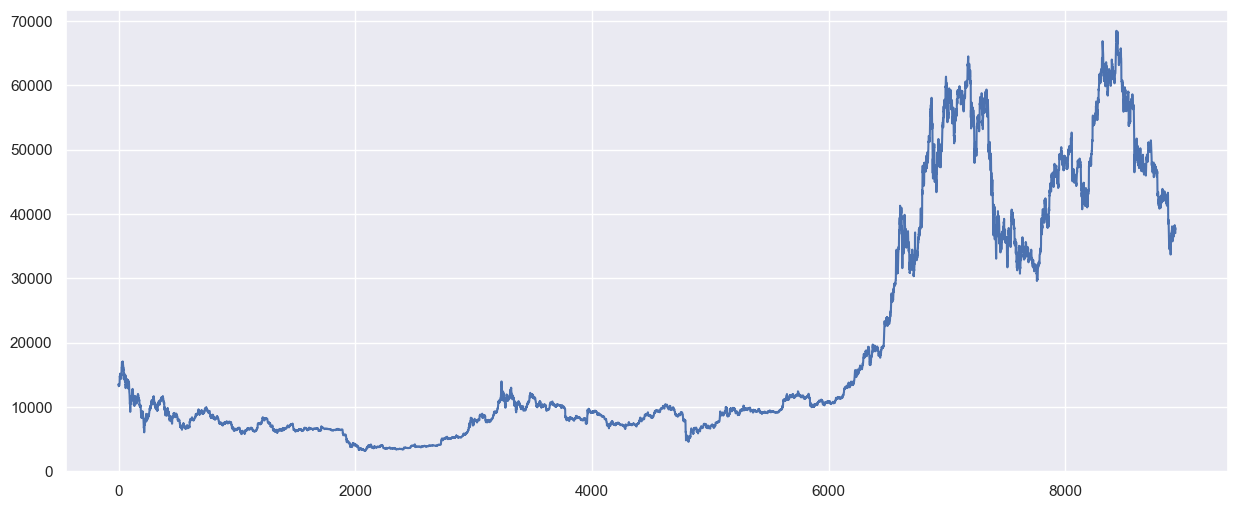

In [41]:
df['close'].plot()

Data Processing before building ARIMA Model

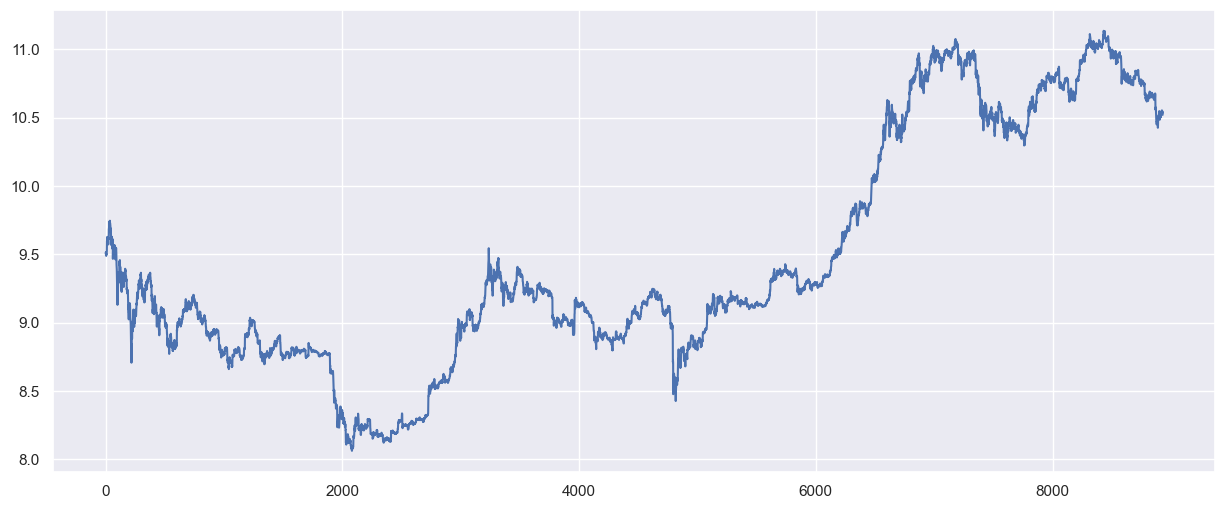

In [42]:
#Applying logarithm to data
df['lts'] = np.log(df['close'])
plt.plot(df['lts'])
lts = df

In [43]:
lts = df['close']

In [44]:
#splitting data in training set and test set

split_ratio = 0.8
split_index = int(len(lts) * split_ratio)
lts_train = lts[:split_index]
lts_test = lts[split_index:]
                  

C:\Users\91758\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


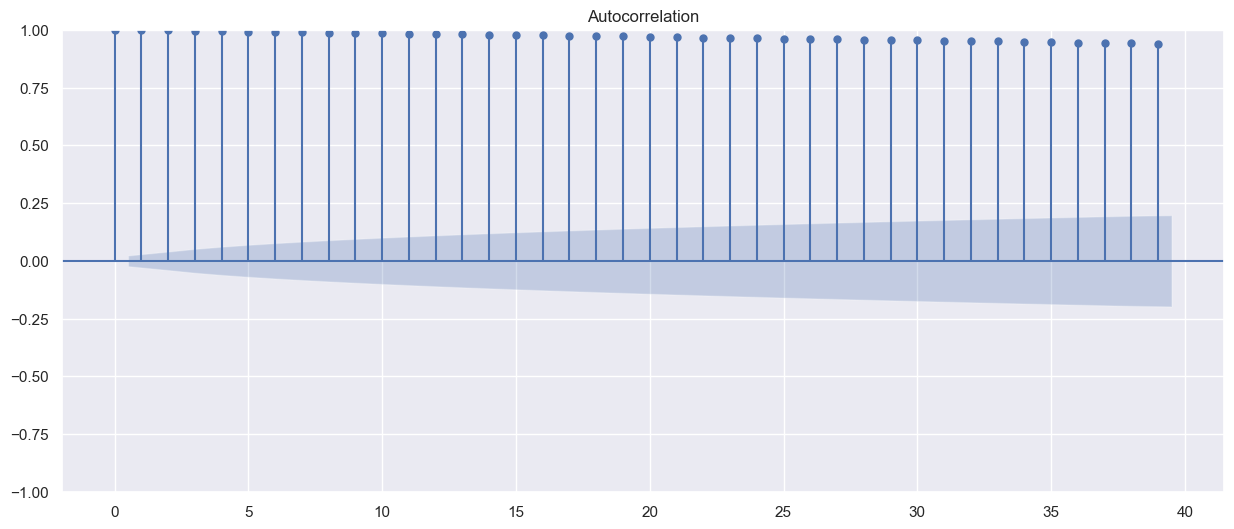

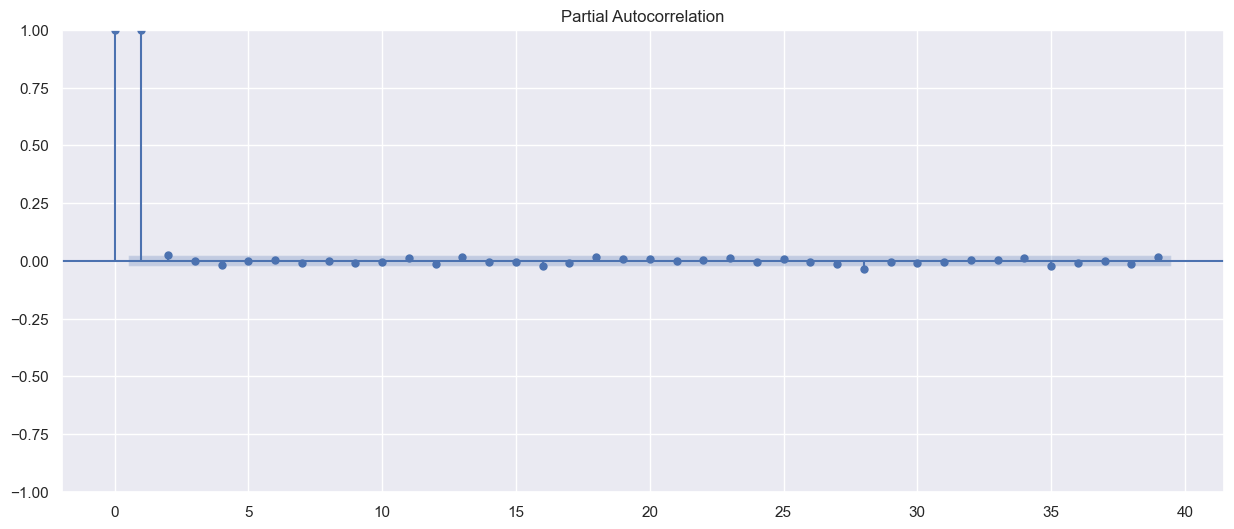

In [45]:
#ACF, PACF test
acf_org = plot_acf(lts_train)
pacf_org = plot_pacf(lts_train)

In [46]:
#ADF Test
adf_test = adfuller(lts_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.9990832775211385


<Axes: >

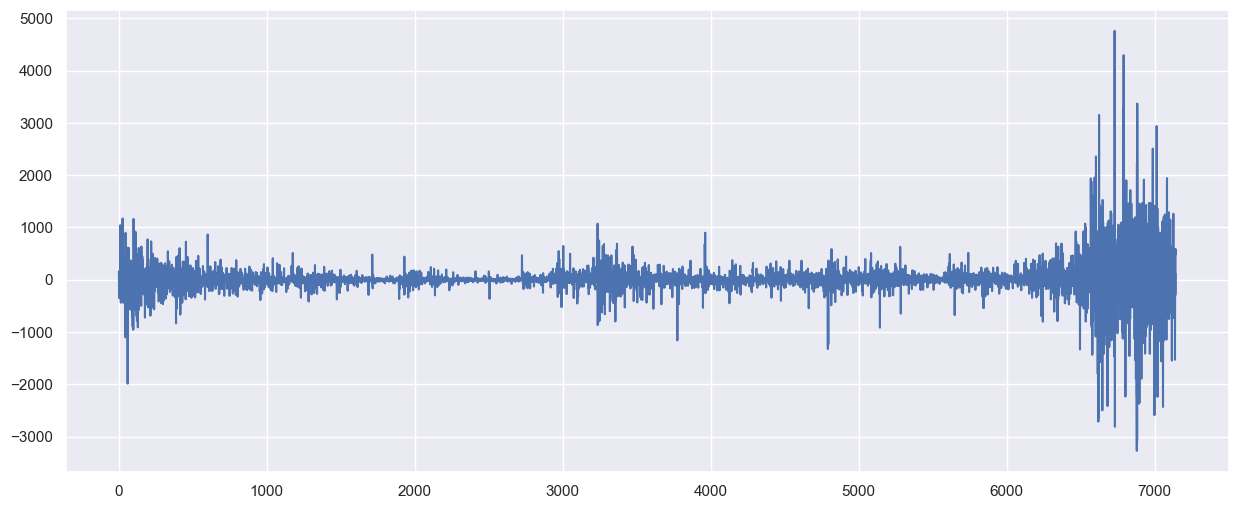

In [47]:
#differencing
lts_train_diff = lts_train.diff().dropna()
lts_train_diff.plot()


C:\Users\91758\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


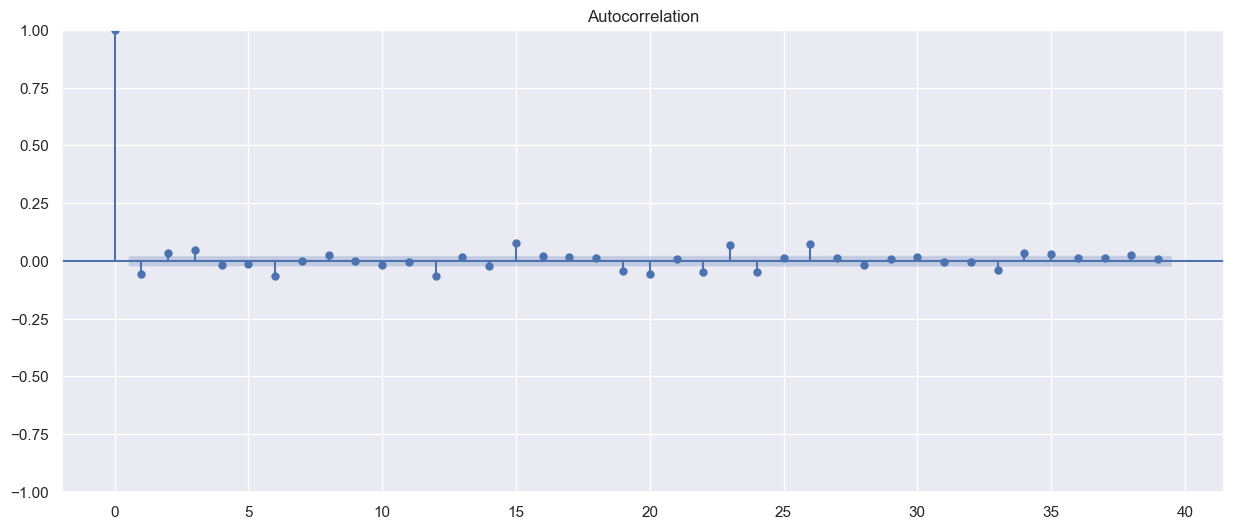

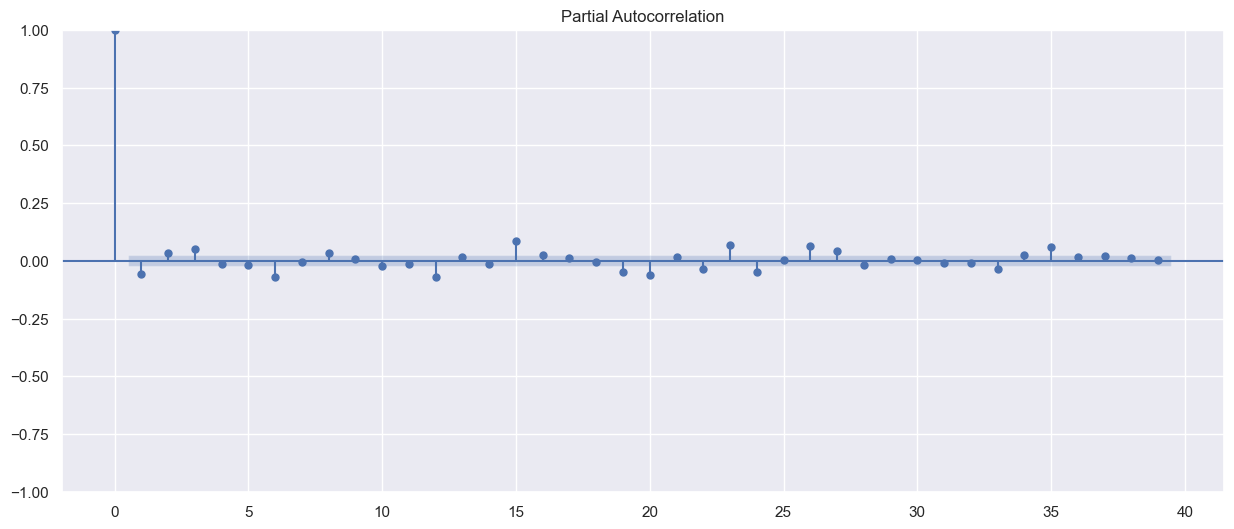

In [48]:
#ACF, PACF test after differncing

acf_org = plot_acf(lts_train_diff)
pacf_org = plot_pacf(lts_train_diff)

In [49]:
#ADF Test
adf_test = adfuller(lts_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 1.7784816895552007e-24


Building and training ARIMA model

In [50]:
model = ARIMA(lts_train,order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary)
              

C:\Users\91758\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91758\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<bound method SARIMAXResults.summary of <statsmodels.tsa.arima.model.ARIMAResults object at 0x0000020DE2673370>>


Residuals and Density plots

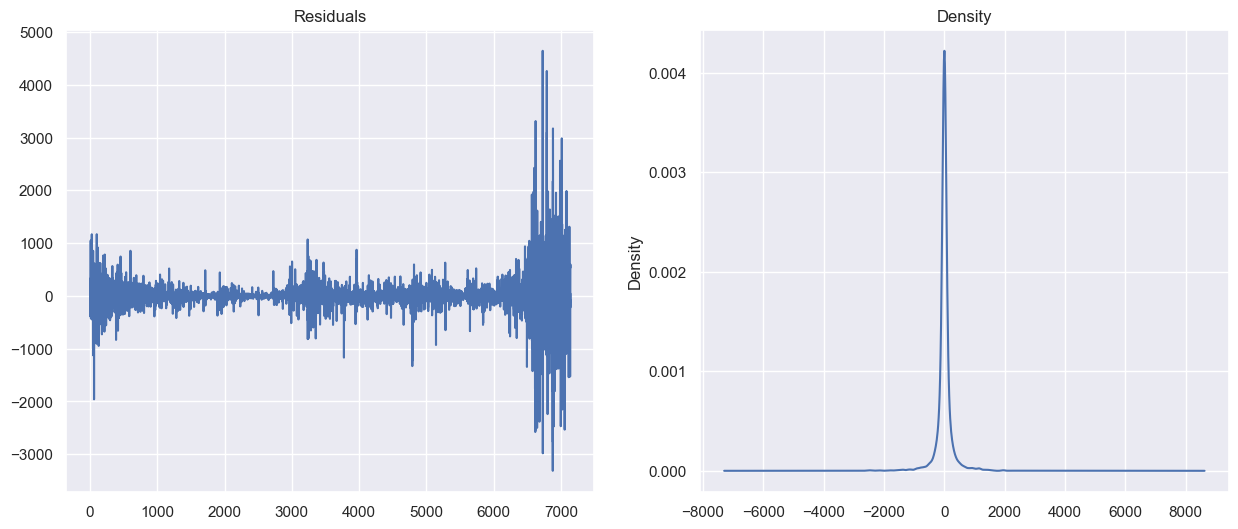

In [51]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title= 'Density', kind='kde', ax=ax[1])
plt.show()

C:\Users\91758\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


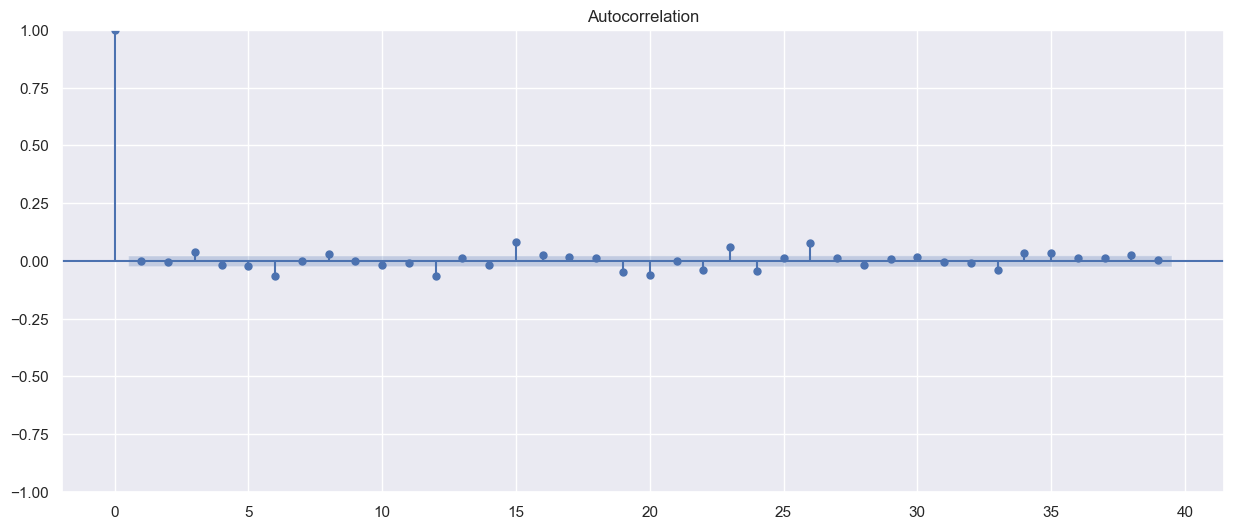

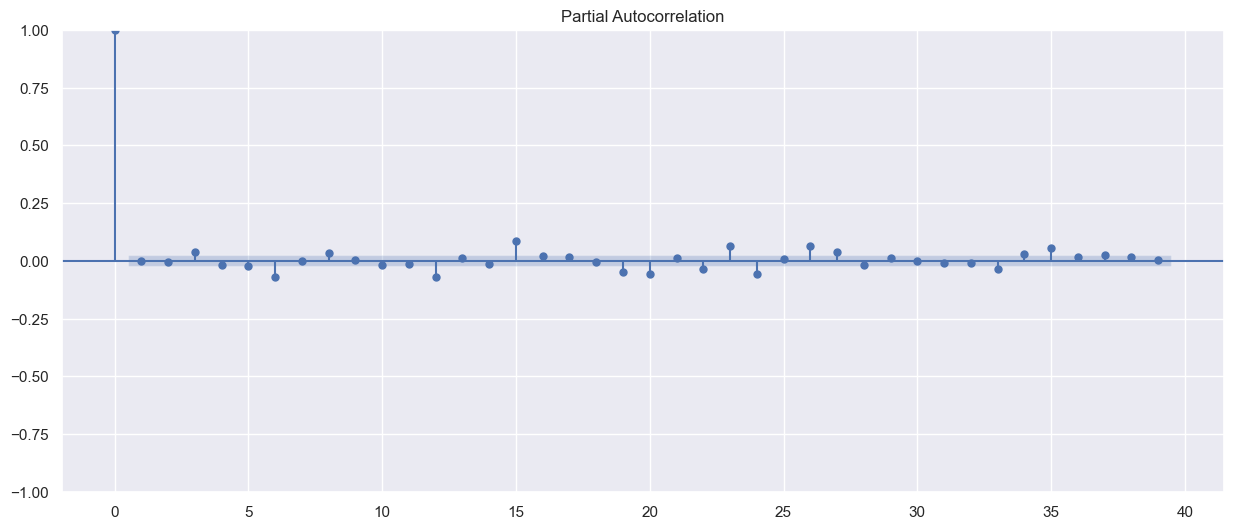

In [52]:
#ACF, PACF tests for residuals

acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

Prediction using the model and plotting the same

Text(0, 0.5, 'Price')

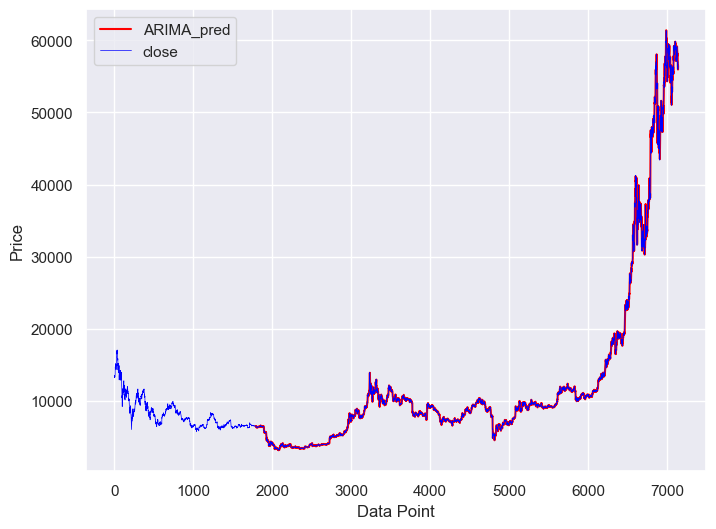

In [53]:
pred_test = model_fit.predict(len(lts_test))

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
pred_test.plot(color = 'red', label = 'ARIMA_pred')
lts_train.plot(color = 'blue', linewidth = '0.5', label = 'close')
plt.legend()
plt.xlabel('Data Point')
plt.ylabel('Price')

